<a href="https://colab.research.google.com/github/SamuelLawrence876/GPT-2-USA-candidates/blob/main/GPT_2_Text_Generating_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://www.kaggle.com/rohanrao/joe-biden-tweets - joe biden

In [ ]:
import pandas as pd

In [ ]:
Trump = pd.read_csv("tweet.csv")
Joe = pd.read_csv("JoeBidenTweets.csv")

In [ ]:
Trump.head(2)

In [ ]:
Joe.head(2)

In [ ]:
trump_list = Trump['content'].tolist()
Joe_list = Joe['tweet'].tolist()

In [ ]:
with open("trump.txt", "w") as output:
    output.write(str(trump_list))

In [ ]:
with open("joe.txt", "w") as output:
    output.write(str(Joe_list))

*Train a GPT-2 w/ GPU For Free* 

Original by [Max Woolf](http://minimaxir.com) modified by [Greg Raiz](http://gregraiz.com)

*Last updated: September 17, 2020

Retrain an advanced text generating neural network on any text dataset **for free on a GPU using Collaboratory** using `gpt-2-simple`!

For more about `gpt-2-simple`, you can visit [this GitHub repository](https://github.com/minimaxir/gpt-2-simple). You can also read my [blog post](https://minimaxir.com/2019/09/howto-gpt2/) for more information how to use this notebook!


To get started:

1. Copy this notebook to your Google Drive to keep it and save your changes. (File -> Save a Copy in Drive)
2. Make sure you're running the notebook in Google Chrome.
3. Run the cells by clicking play between the [ &nbsp;  ] 


In [ ]:
model= "355M"  #@param ['124M', '355M', '774M', '1558M']
# Note that these are millions of parameters.  
# The 774M model is 3GB,
# the 1558M model is 6GB. Start small, before going big.

iterations =  1000#@param {type: "number"}
# If we're training, how many iterations do we want?

trainingName = 'tweets' #@param {type: "string"}   
# Each new model you train should be named. 

file_name = 'trump.txt'  #@param {type: "string"}
# If you have a training file in your Google drive, specify the filename
# that will be used. 


%tensorflow_version 1.x        # This uses an older version of tensorflow
!pip install -q gpt-2-simple   # You will get warnings but it's Ok. 
import gpt_2_simple as gpt2
from datetime import datetime
from google.colab import files


## GPU

Colaboratory uses either a Nvidia T4 GPU or an Nvidia K80 GPU. The T4 is slightly faster than the old K80 for training GPT-2, and has more memory allowing you to train the larger GPT-2 models and generate more text.

You can verify which GPU is active by running the cell below.

In [ ]:
!nvidia-smi

## Downloading GPT-2

If you're retraining a model on new text, you need to download the GPT-2 model first. 

There are three released sizes of GPT-2:

* `124M` (default): the "small" model, 500MB on disk.
* `355M`: the "medium" model, 1.5GB on disk.
* `774M`: the "large" model, cannot currently be finetuned with Colaboratory but can be used to generate text from the pretrained model (see later in Notebook)
* `1558M`: the "extra large", true model. Will not work if a K80 GPU is attached to the notebook. (like `774M`, it cannot be finetuned).

Larger models have more knowledge, but take longer to finetune and longer to generate text. You can specify which base model to use by changing `model_name` in the cells below.

The next cell downloads it from Google Cloud Storage and saves it in the Colaboratory VM at `/models/<model_name>`.

This model isn't permanently saved in the Colaboratory VM; you'll have to redownload it if you want to retrain it at a later time.

In [ ]:
# This will download the model if it hasn't been downloaded. 
# Each time you start a new Colab session you get a clean/new machine. 
# You can use the files tab on the right to see what files and models are installed and loaded

gpt2.download_gpt2(model_name=model)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Mounting Google Drive

The best way to get input text to-be-trained into the Colaboratory VM, and to get the trained model *out* of Colaboratory, is to route it through Google Drive *first*.

Running this cell (which will only work in Colaboratory) will mount your personal Google Drive in the VM, which later cells can use to get data in/out. (it will ask for an auth code; that auth is not saved anywhere)

In [ ]:
gpt2.mount_gdrive()
# You will need to get an authorization code to connect your GDrive. 
# Copy the text, paste it and hit enter. 


## Uploading a Text File to be Trained to Colaboratory

In the Colaboratory Notebook sidebar on the left of the screen, select *Files*. It may look like a folder icon. 
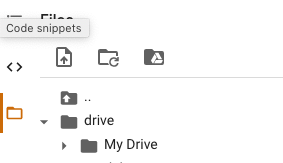


Upload **any smaller text file**  (<10 MB) and update the file name in the setup script. 

If your text file is larger than 10MB, it is recommended to upload that file to Google Drive first, then copy that file from Google Drive to the Colaboratory VM.  The filename is specified at the top init function. 

In [ ]:
gpt2.copy_file_from_gdrive(file_name) 
print(file_name)

## Finetune GPT-2

The next cell will start the actual finetuning of GPT-2. It creates a persistent TensorFlow session which stores the training config, then runs the training for the specified number of `steps`. (to have the finetuning run indefinitely, set `steps = -1`)

The model checkpoints will be saved in `/checkpoint/run1` by default. The checkpoints are saved every 500 steps (can be changed) and when the cell is stopped.

The training might time out after 4ish hours; make sure you end training and save the results so you don't lose them!

**IMPORTANT NOTE:** If you want to rerun this cell, **restart the VM first** (Runtime -> Restart Runtime). You will need to rerun imports but not recopy files.



Other optional-but-helpful parameters for `gpt2.finetune`:


*  **`restore_from`**: Set to `fresh` to start training from the base GPT-2, or set to `latest` to restart training from an existing checkpoint.
* **`sample_every`**: Number of steps to print example output
* **`print_every`**: Number of steps to print training progress.
* **`learning_rate`**:  Learning rate for the training. (default `1e-4`, can lower to `1e-5` if you have <1MB input data)
*  **`run_name`**: subfolder within `checkpoint` to save the model. This is useful if you want to work with multiple models (will also need to specify  `run_name` when loading the model)
* **`overwrite`**: Set to `True` if you want to continue finetuning an existing model (w/ `restore_from='latest'`) without creating duplicate copies. 

In [ ]:
sess = gpt2.start_tf_sess()
gpt2.finetune(sess,
              dataset=file_name,    # Filename, Model and Training Name are specified in the Init Function
              model_name=model,
              steps=iterations,
              restore_from='latest',
              overwrite=True,
              run_name = trainingName,
              print_every=100,
              sample_every=200,save_every=500)
## After it runs, save it to GDrive so we can get it for future runs. 
gpt2.copy_checkpoint_to_gdrive(run_name=trainingName)

After the model is trained, it gets copied to your Google Drive. This is done because the Colab files will go away  once you disconnect from the session. The checkpoint folder is copied as a `.rar` compressed file; you can download it and uncompress it locally if needed.

Once a model is trained you can also run it on your local computer, it's strongly recommended you copy it to Drive first, then download from there. 

You're done! Feel free to go to the **Generate Text From The Trained Model** section to generate text based on your retrained model.

## Load a Trained Model Checkpoint

Running the next cell will copy the `.rar` checkpoint file from your Google Drive into the Colaboratory VM.  If you just generated the model, you don't have to run this but it doesn't hurt anything. 

In [ ]:
gpt2.copy_checkpoint_from_gdrive(run_name=trainingName)

The next cell will allow you to load the retrained model checkpoint + metadata necessary to generate text.

**IMPORTANT NOTE:** If you want to rerun this cell, **restart the VM first** (Runtime -> Restart Runtime). You will need to rerun imports from step one, but not recopy files.

In [ ]:
sess = gpt2.start_tf_sess()
#gpt2.load_gpt2(sess, run_name=trainingName)

## Generate Text From The Trained Model

After you've trained the model or loaded a retrained model from checkpoint, you can now generate text. `generate` generates a single text from the loaded model.

In [ ]:
gpt2.generate(sess, length=250,temperature=0.7,prefix="T",nsamples=5,batch_size=5)

In [ ]:
text_creativity = 70 #@param {type: "slider", min: 50, max: 100}
# Changes how wacky the text gets. 
gpt2.generate(sess, run_name=trainingName,temperature=(text_creativity/100))


If you're creating an API based on your model and need to pass the generated text elsewhere, you can do `text = gpt2.generate(sess, return_as_list=True)[0]`

You can also pass in a `prefix` to the generate function to force the text to start with a given character sequence and generate text from there (good if you add an indicator when the text starts).

You can also generate multiple texts at a time by specifing `nsamples`. Unique to GPT-2, you can pass a `batch_size` to generate multiple samples in parallel, giving a massive speedup (in Colaboratory, set a maximum of 20 for `batch_size`).

Other optional-but-helpful parameters for `gpt2.generate` and friends:

*  **`length`**: Number of tokens to generate (default 1023, the maximum)
* **`temperature`**: The higher the temperature, the crazier the text (default 0.7, recommended to keep between 0.7 and 1.0)
* **`top_k`**: Limits the generated guesses to the top *k* guesses (default 0 which disables the behavior; if the generated output is super crazy, you may want to set `top_k=40`)
* **`top_p`**: Nucleus sampling: limits the generated guesses to a cumulative probability. (gets good results on a dataset with `top_p=0.9`)
* **`truncate`**: Truncates the input text until a given sequence, excluding that sequence (e.g. if `truncate='<|endoftext|>'`, the returned text will include everything before the first `<|endoftext|>`). It may be useful to combine this with a smaller `length` if the input texts are short.
*  **`include_prefix`**: If using `truncate` and `include_prefix=False`, the specified `prefix` will not be included in the returned text.

In [ ]:
gpt2.generate(sess, 
              run_name=trainingName,
              length=150,
              prefix="I once saw a cow",
              nsamples=5,
              batch_size=5
              )

For bulk generation, you can generate a large amount of text to a file and sort out the samples locally on your computer. The next cell will generate a generated text file with a unique timestamp.

You can rerun the cells as many times as you want for even more generated texts!

In [ ]:
gen_file = 'gpt2_gentext_{:%Y%m%d_%H%M%S}.txt'.format(datetime.utcnow())

gpt2.generate_to_file(sess, 
              run_name=trainingName,
              destination_path=gen_file,
              temperature=0.7,
              length=500,
              nsamples=100,
              batch_size=20
              )


In [ ]:
# may have to run twice to get file to download
files.download(gen_file)

## Generate Text From The Pretrained Model

If you want to generate text from the pretrained model, not a finetuned model, pass `model_name` to `gpt2.load_gpt2()` and `gpt2.generate()`.

This is currently the only way to generate text from the 774M or 1558M models with this notebook.  You may need to restart the model to have it load this. 

In [ ]:
sess = gpt2.start_tf_sess()

gpt2.load_gpt2(sess, model_name=model,run_name=trainingName)

In [ ]:
gpt2.generate(sess,
              model_name=model,
              prefix="What do you call an entrepreneur",
              length=50,
              temperature=0.7,
              top_p=0.9,
              nsamples=5,  
              batch_size=5
              )



# Etcetera

If the notebook has errors (e.g. GPU Sync Fail), force-kill the Colaboratory virtual machine and restart it with the command below:

In [ ]:
!kill -9 -1

# LICENSE

MIT License

Copyright (c) 2019 Max Woolf

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.